# Import Libraries

In [3]:
import pandas as pd
import numpy as np
from causalml.inference.meta import LRSRegressor, XGBTRegressor,BaseRRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from causalml.inference.meta import BaseXLearner, BaseSLearner, BaseTLearner, BaseRLearner
from causalml.inference.meta.explainer import Explainer
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.pipeline import Pipeline

# Import Data

In [4]:
df = pd.read_csv('/Users/qianlou/Documents/GitHub/Customer-Personality-Analysis-2.0/Data/Preprocessed Data/Final Preprocessed Data.csv')

# Causal Inference Pipeline

In [9]:
def causal_inference_pipeline(df, X_cols, treatments):
    outcomes = ['Recency', 'Total_purchase', 'Total_amount']
    results = []

    for outcome in outcomes:
        for treatment in treatments:
            # Prepare covariates
            covariates = [col for col in X_cols if col != treatment and col != outcome]
            if outcome == 'Total_purchase':
                covariates.remove('Total_amount')
            elif outcome == 'Total_amount':
                covariates.remove('Total_purchase')
            X = df[covariates]
            y = df[outcome]
            t = df[treatment]

            # Split data into training and testing sets
            X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
                X, y, t, test_size=0.2, random_state=42)

            lowest_rmse = float('inf')
            best_model = None
            best_ate = None
            best_shap_values = None

            # Iterate over model types
            for model_type in [XGBRegressor, XGBTRegressor]:
                try:
                    # Model instantiation
                    if model_type == XGBRegressor:
                        model = model_type()
                        model.fit(X_train, y_train)
                        xgb_model = XGBRegressor()
                        xgb_model.fit(X_train, y_train)
                        explainer = shap.Explainer(xgb_model)
                        shap_values = explainer(X_test)
                    else:
                        model = model_type()
                        model.fit(X_train, t_train, y_train)

                    # Estimate ATE
                    ate_mean, ate_std = cross_validate_ate(model, X, t, y)

                    # Predictions for MSE calculation
                    y_pred = model.predict(X_test)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

                    if rmse < lowest_rmse:
                        lowest_rmse = rmse
                        best_model = model
                        best_ate = ate_mean
                        best_shap_values = shap_values

                except Exception as e:
                    print(f"Error training model for treatment {treatment} and outcome {outcome}:", e)

            if best_shap_values is not None:
                plt.title(f'SHAP Values for Treatment: {treatment}, Outcome: {outcome} ({best_model.__class__.__name__})')
                shap.summary_plot(best_shap_values, X_test, plot_type="bar")
                plt.show()

                plt.title(f'SHAP Values for Treatment: {treatment}, Outcome: {outcome} ({best_model.__class__.__name__})')
                shap.plots.beeswarm(best_shap_values, max_display=30)
                plt.show()

            results.append({
                'Outcome': outcome,
                'Treatment': treatment,
                'Model Type': best_model.__class__.__name__ if best_model else None,
                'ATE': best_ate,
                'RMSE': lowest_rmse
            })

    results_df = pd.DataFrame(results)

    return results_df

def cross_validate_ate(estimator, X, treatment, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    ate_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        treatment_train, treatment_test = treatment.iloc[train_index], treatment.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        estimator.fit(X_train, treatment_train, y_train)
        ate_estimate = np.mean(estimator.predict(X_test))
        ate_scores.append(ate_estimate)

    return np.mean(ate_scores), np.std(ate_scores)



[18:29:27] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


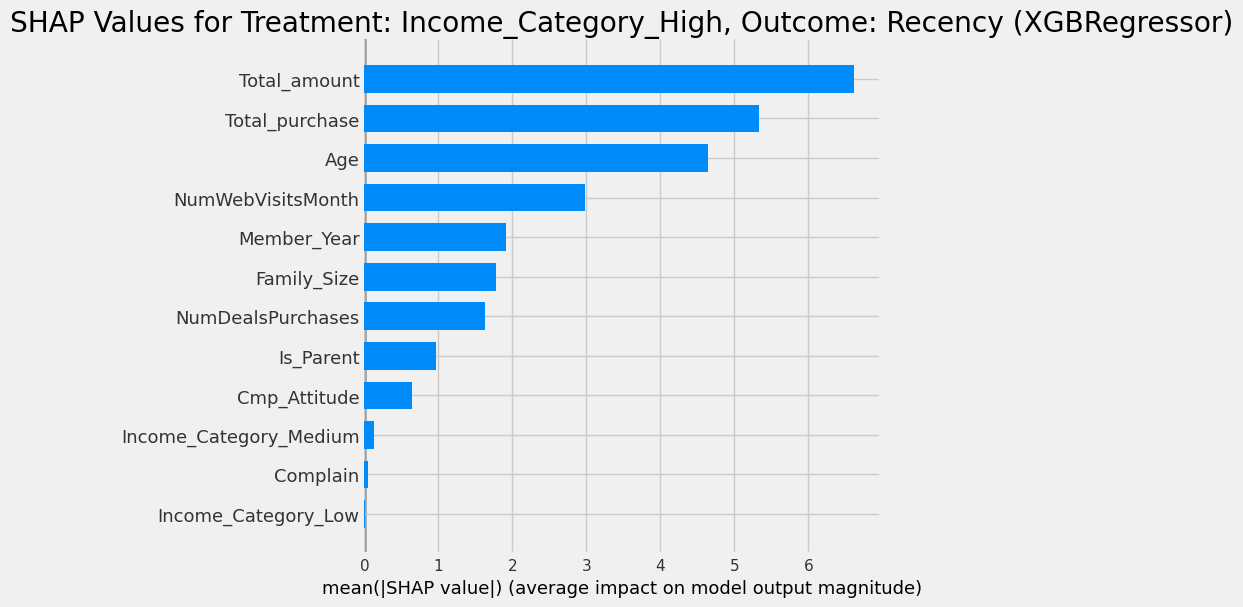

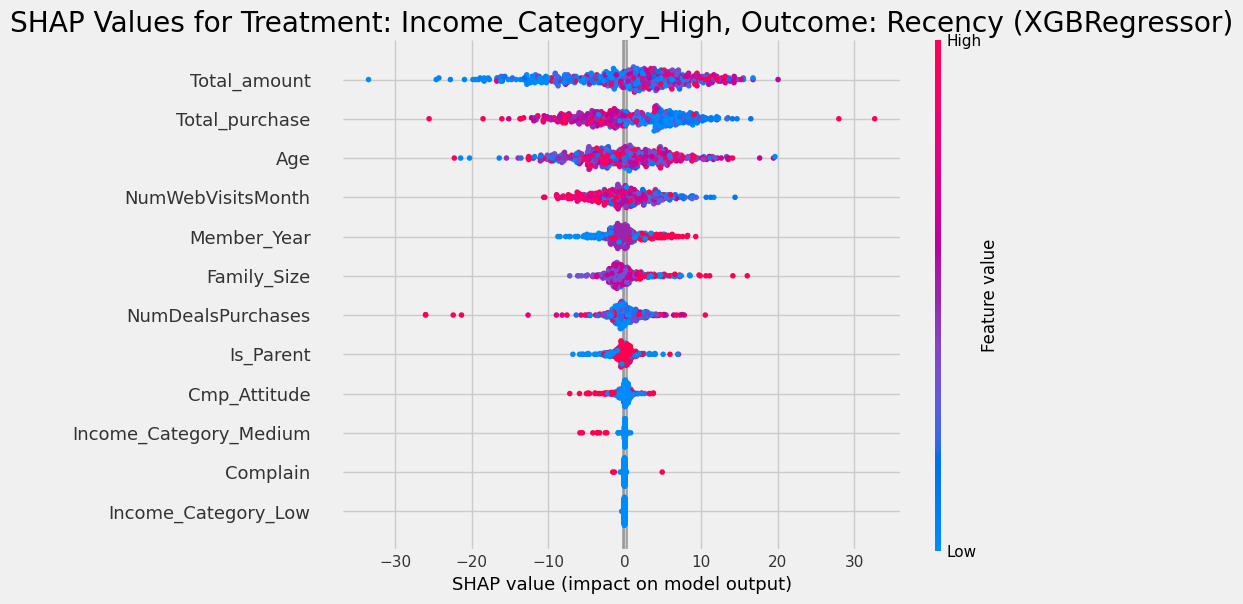

[18:29:30] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


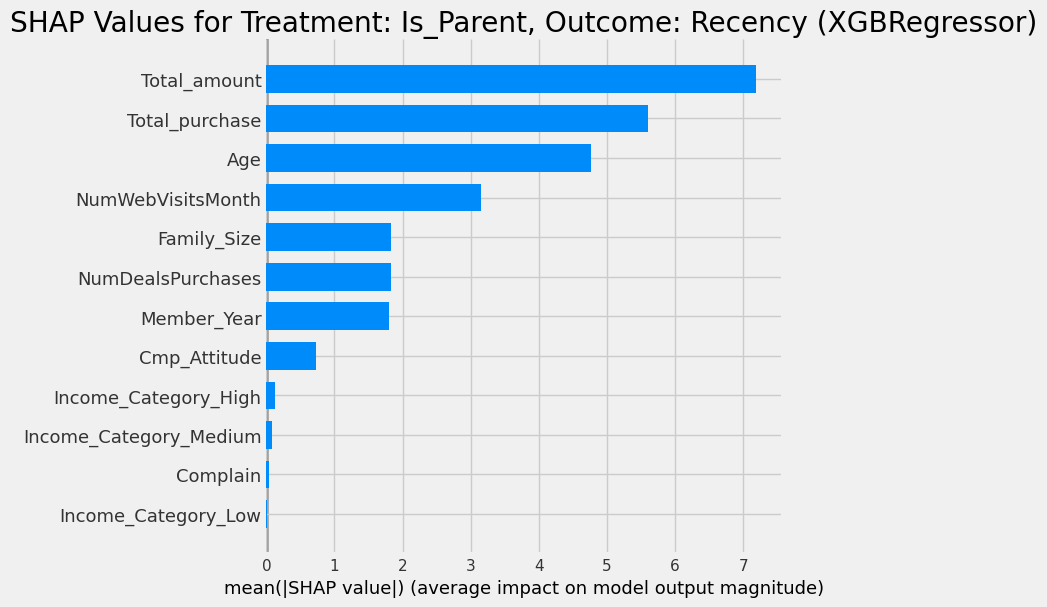

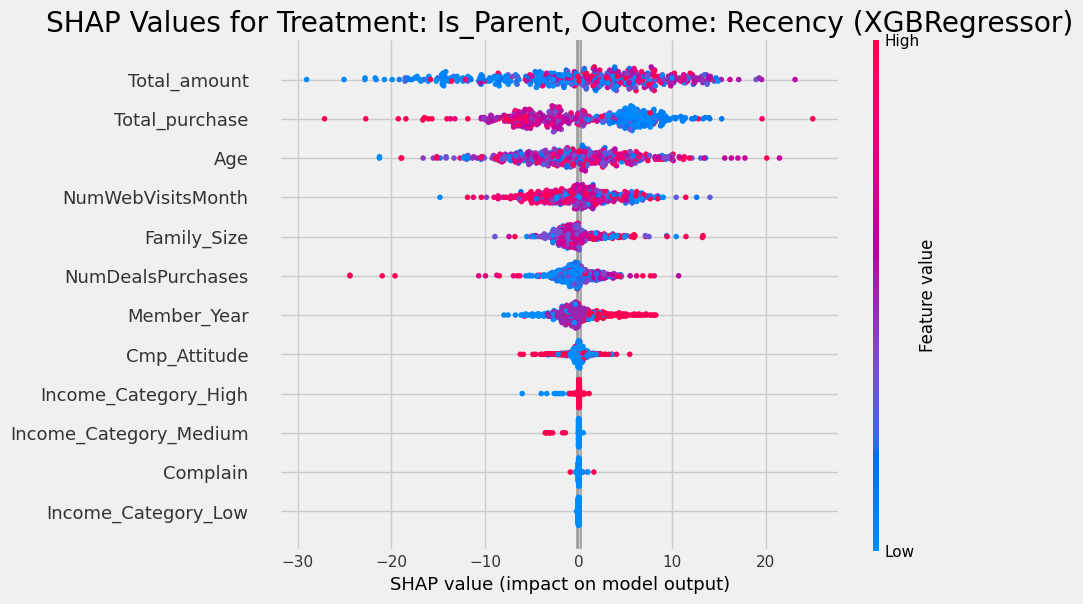

[18:29:34] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


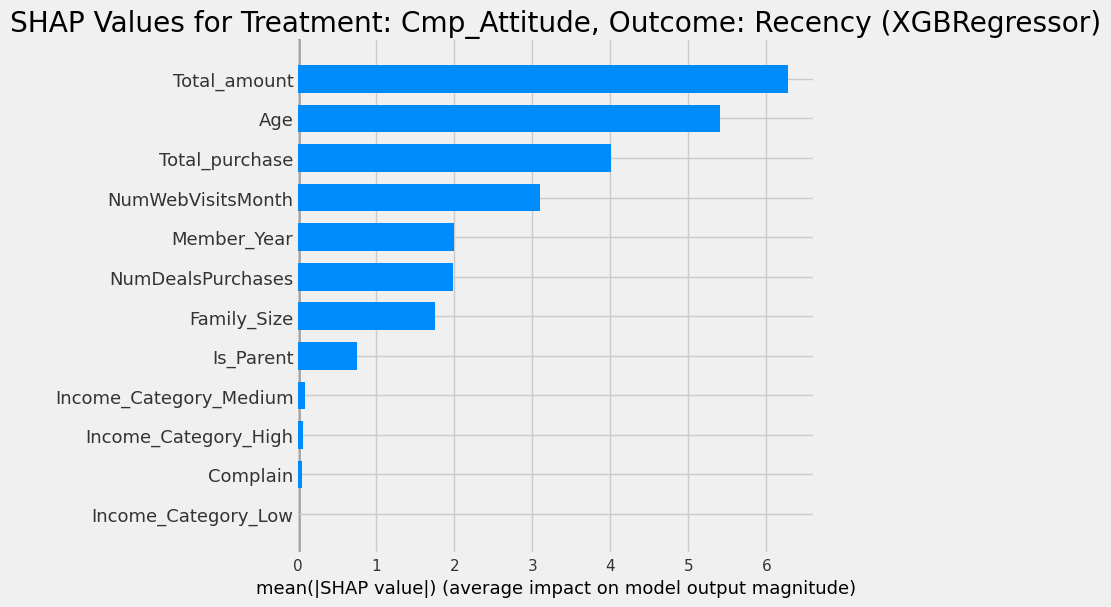

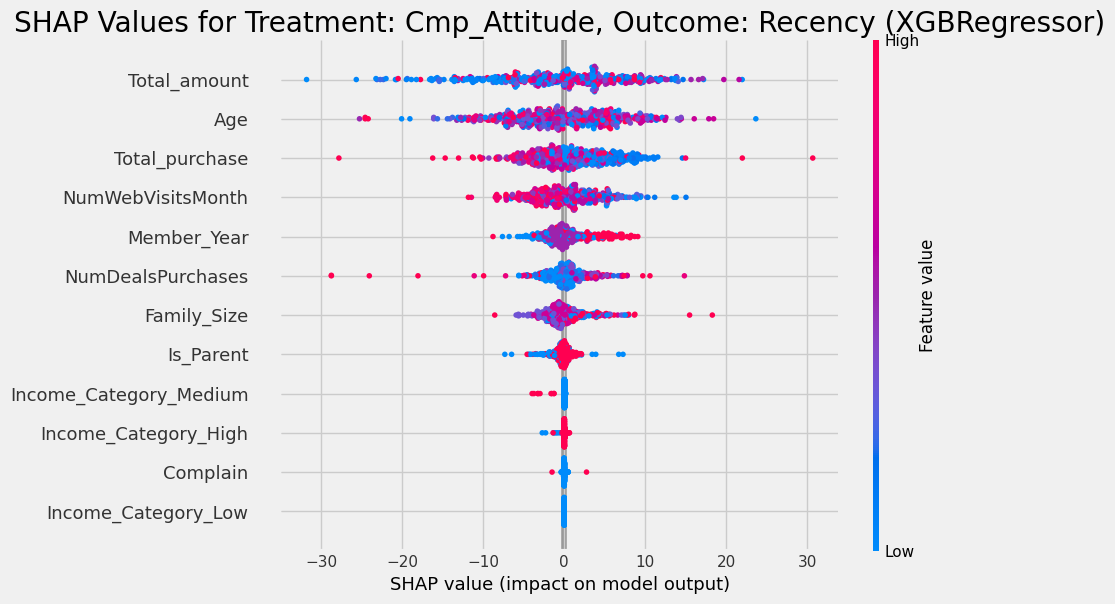

[18:29:38] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


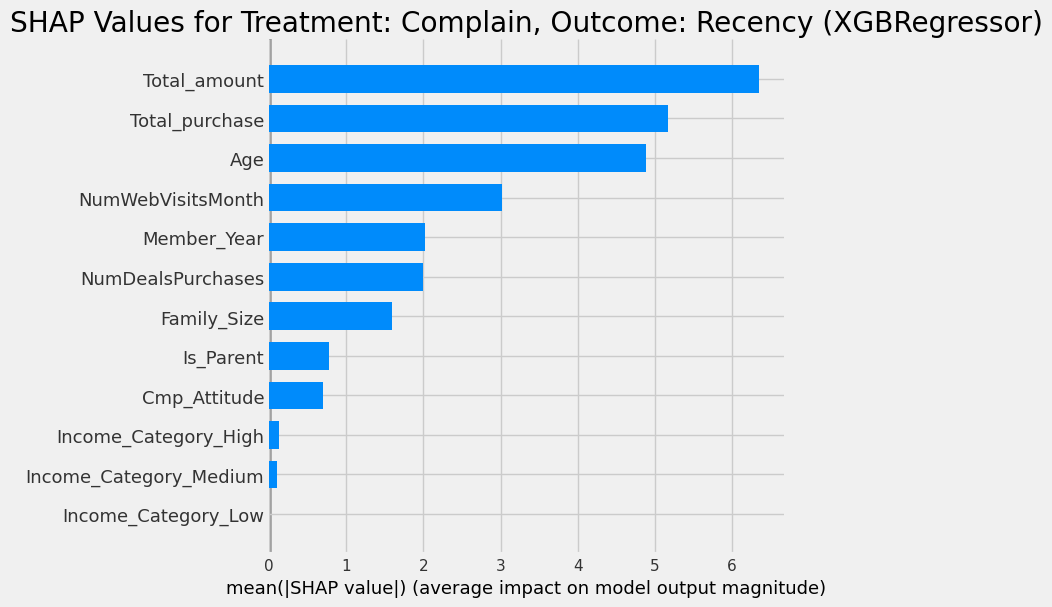

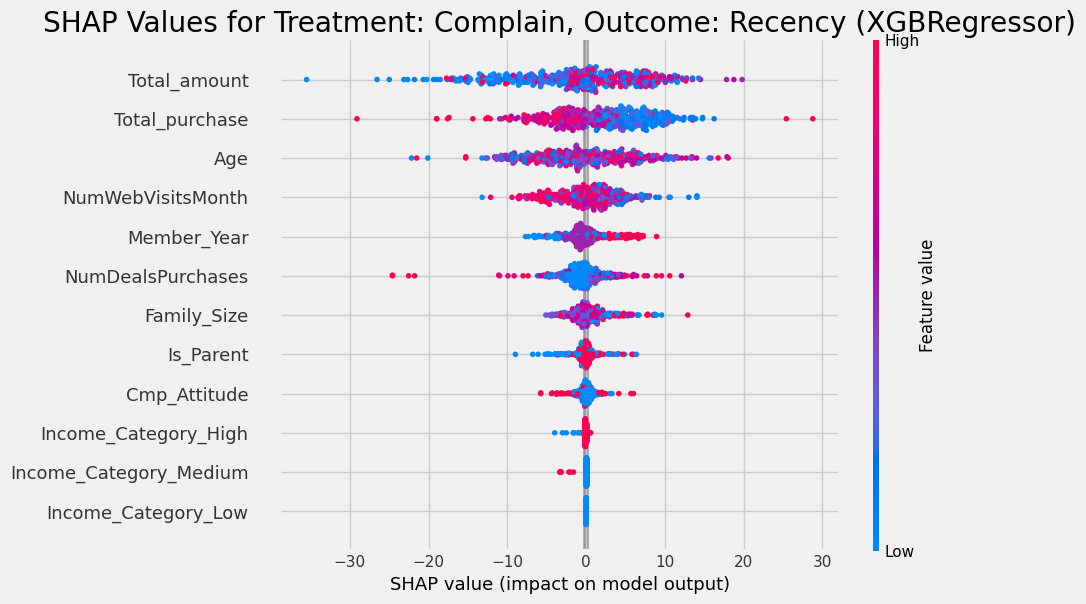

[18:29:41] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


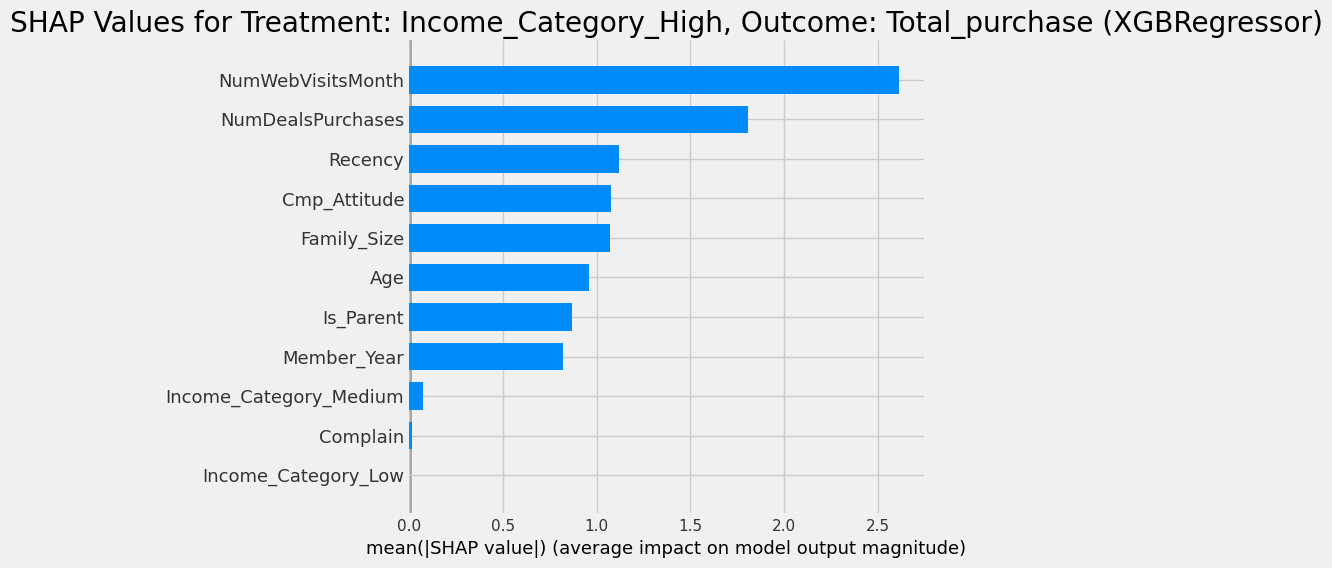

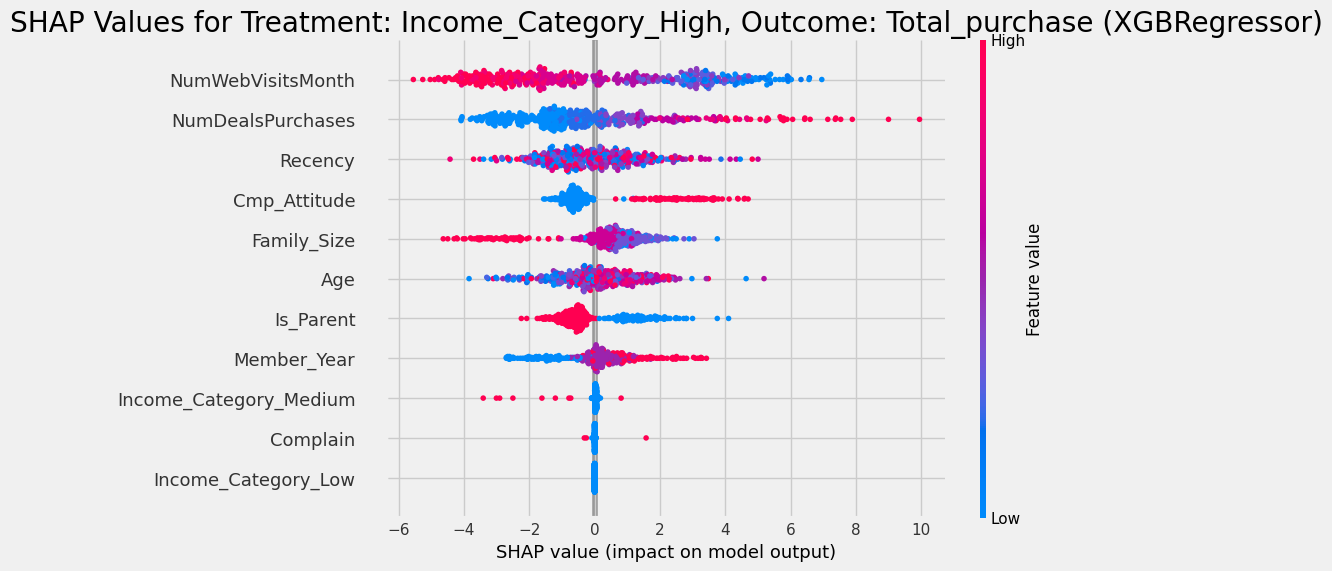

[18:29:44] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[18:29:45] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


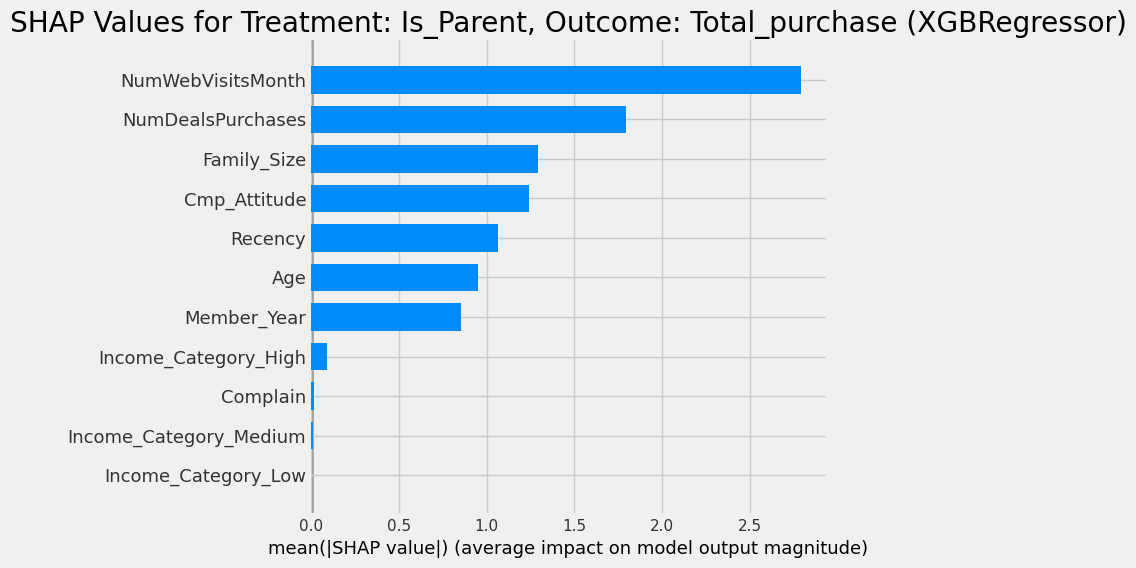

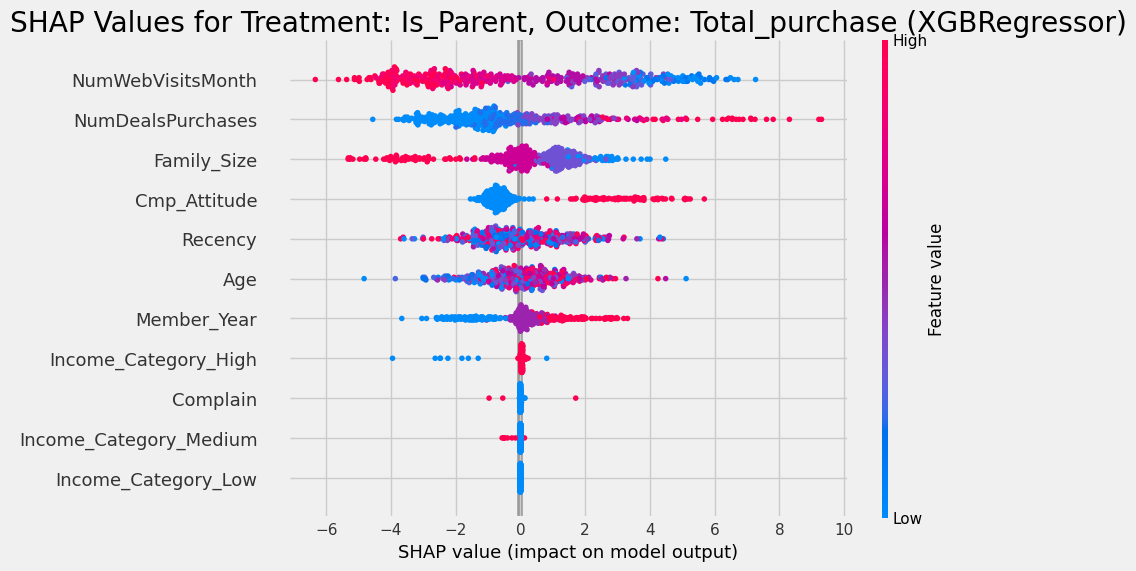

[18:29:48] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


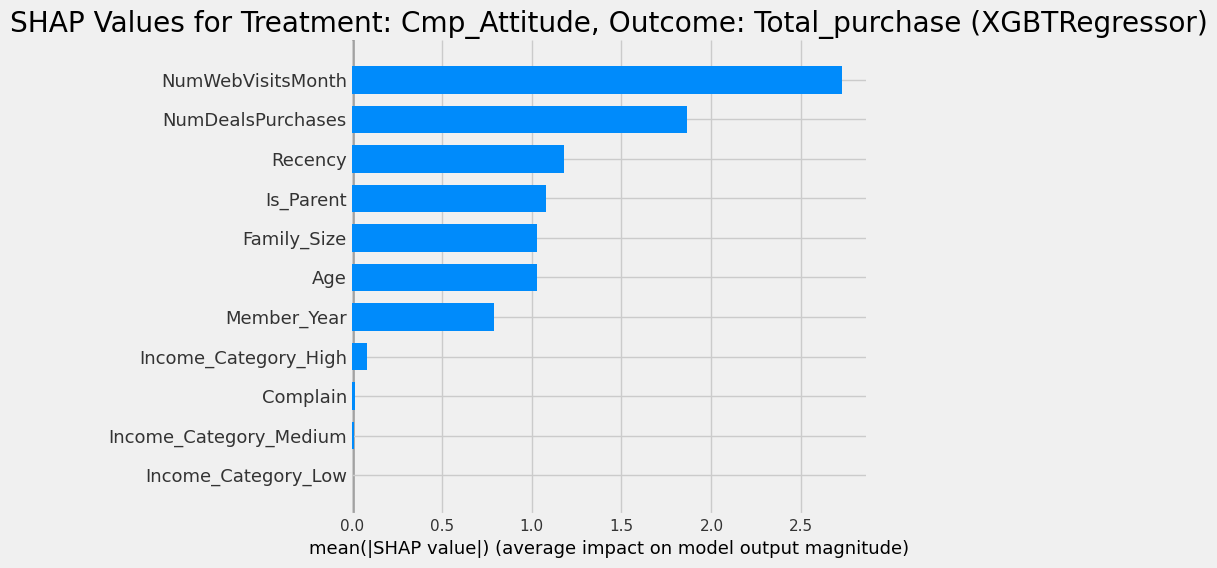

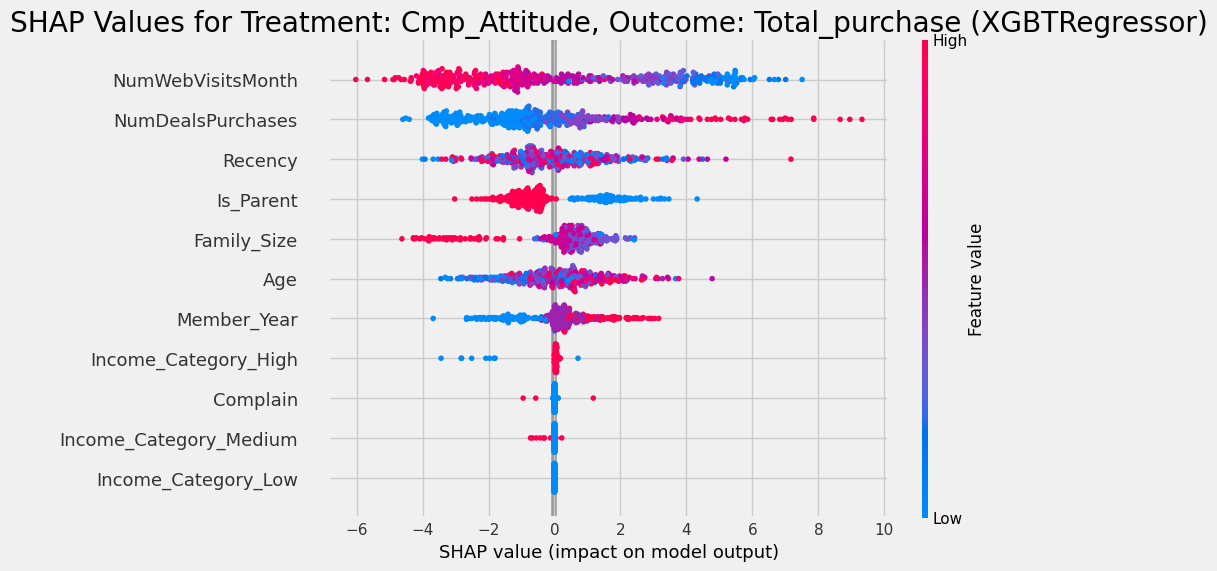

[18:29:51] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


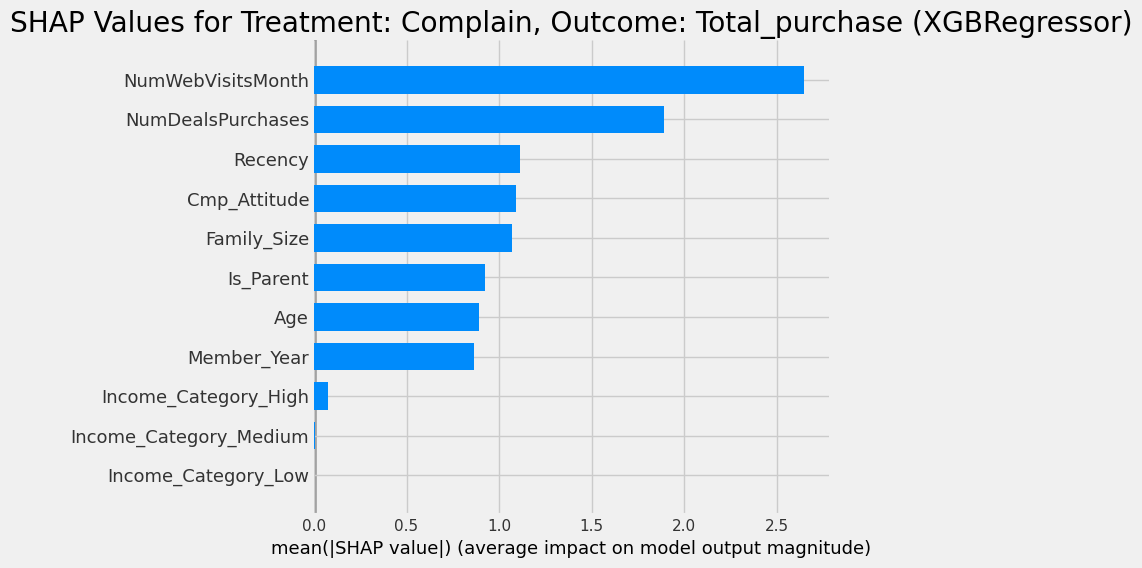

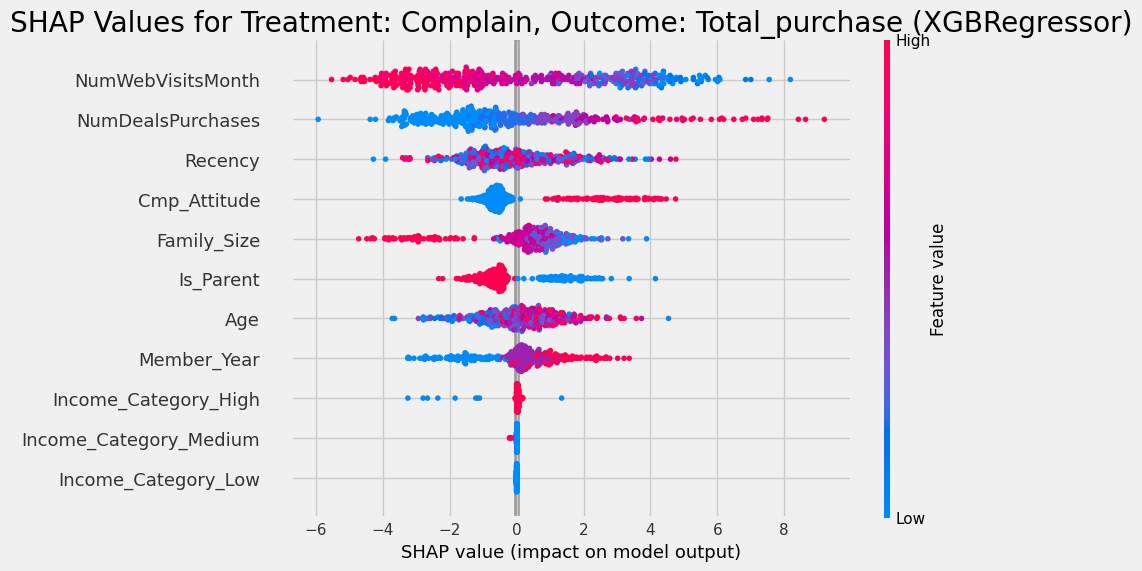

[18:29:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


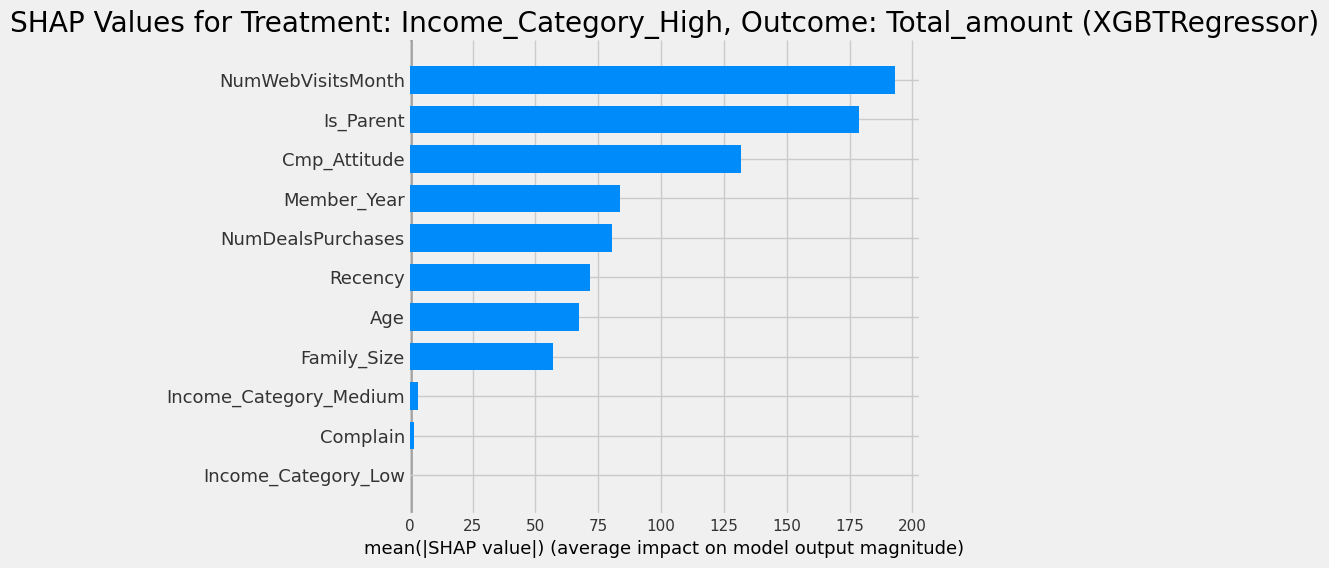

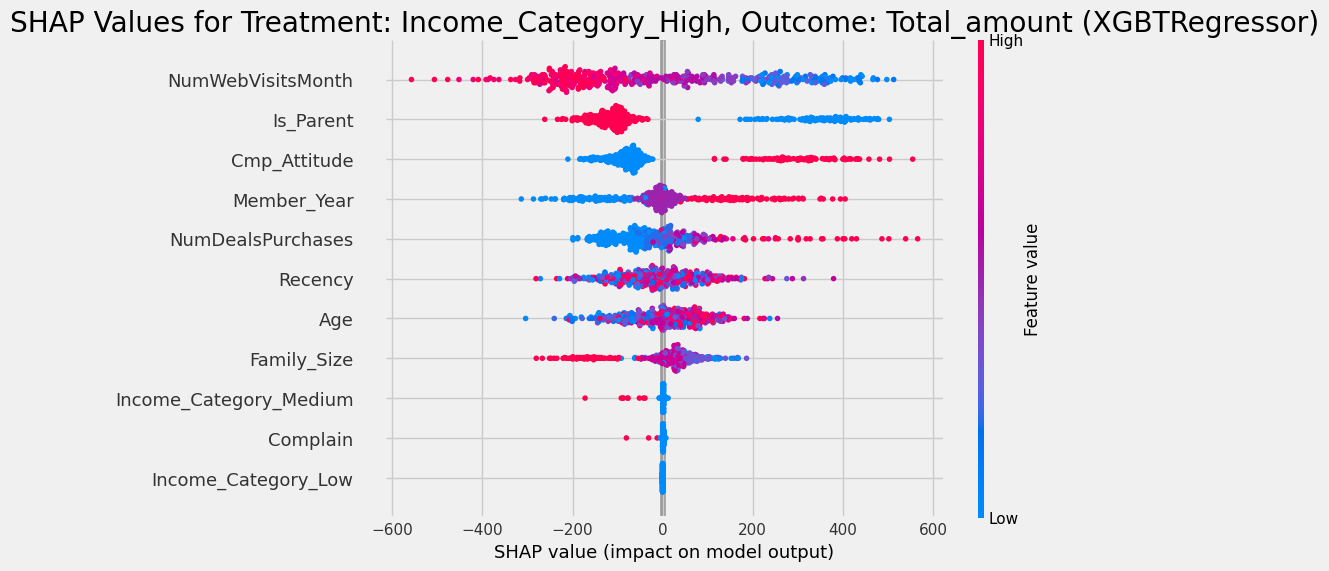

[18:29:57] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


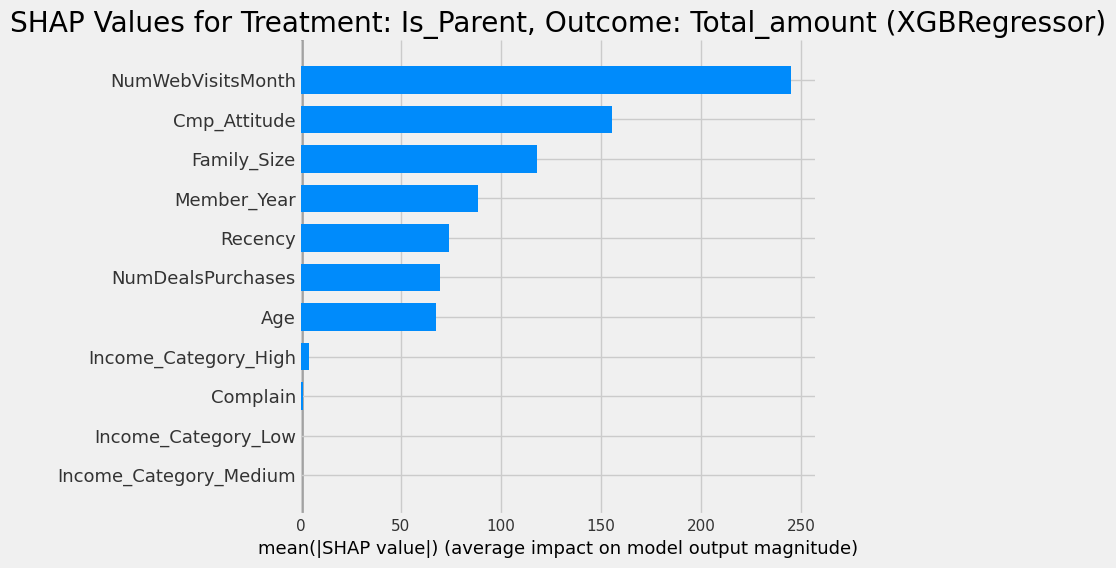

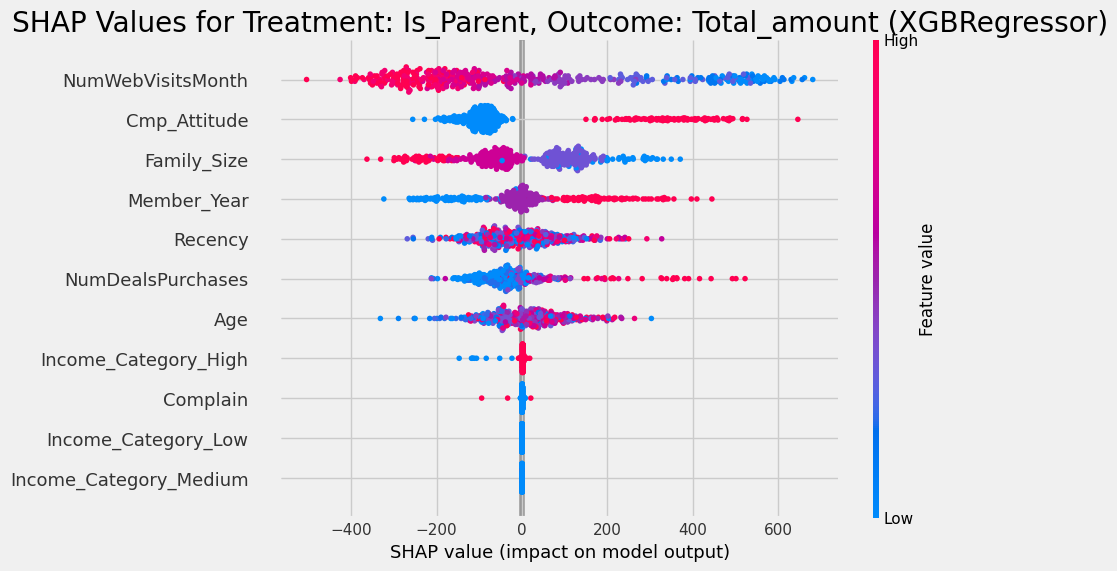

[18:30:00] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[18:30:01] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


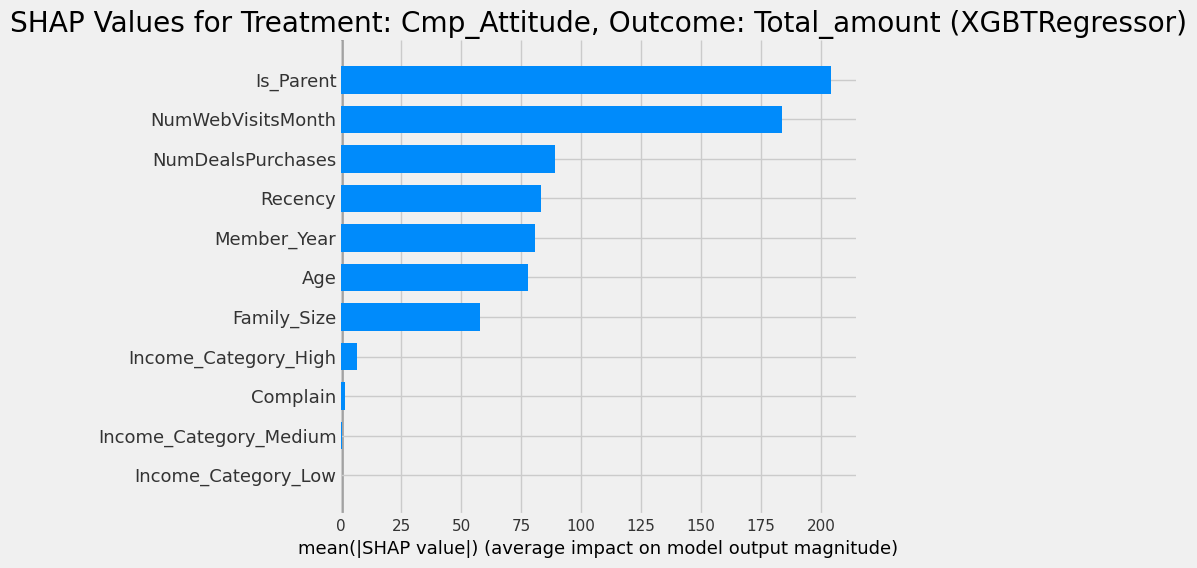

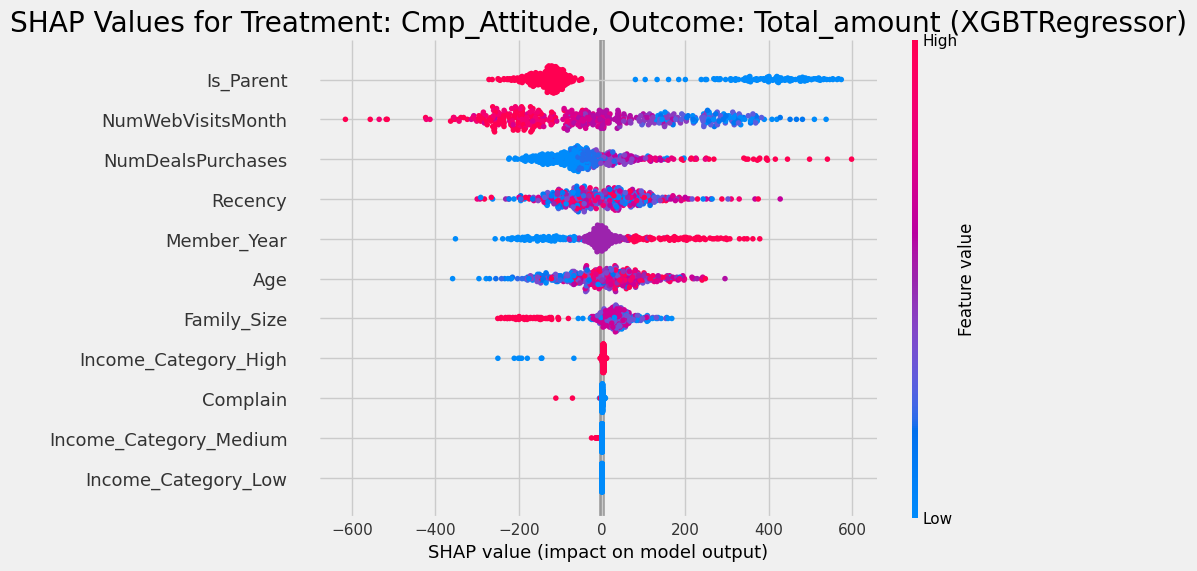

[18:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


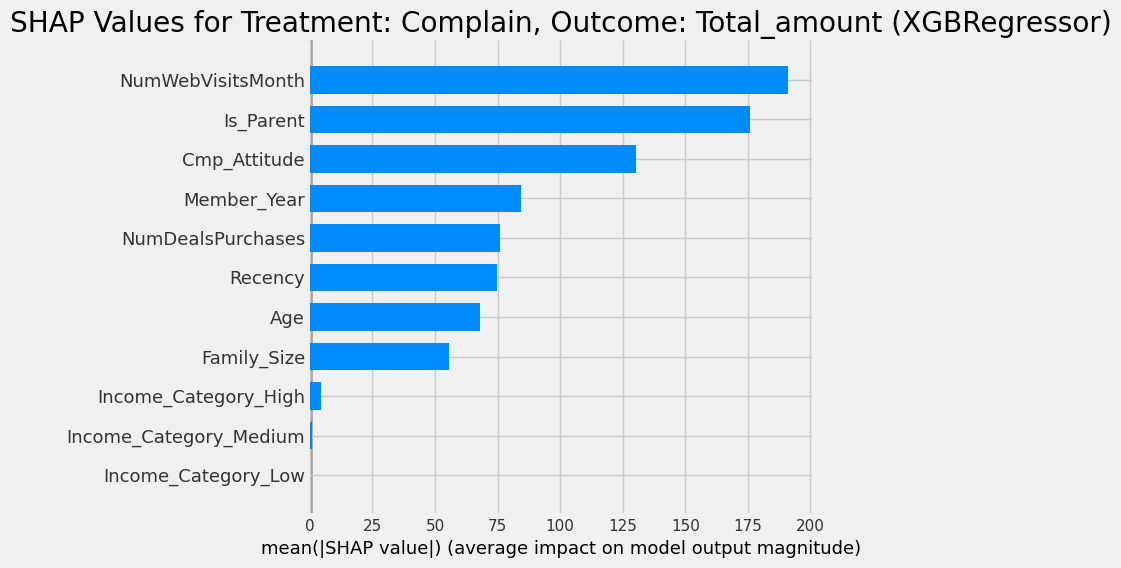

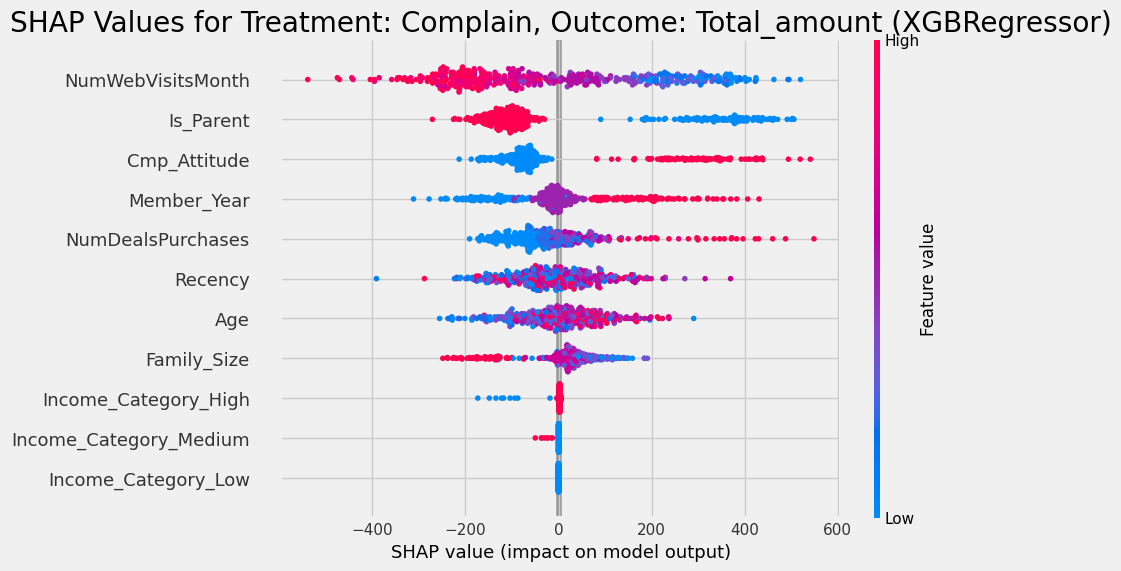

,Outcome,Treatment,Model Type,ATE,RMSE
0,Recency,Income_Category_High,XGBRegressor,0.984333,54.668270
1,Recency,Is_Parent,XGBRegressor,0.714969,54.865256
2,Recency,Cmp_Attitude,XGBRegressor,0.217046,55.342698
3,Recency,Complain,XGBRegressor,0.012355,55.493829
4,Total_purchase,Income_Category_High,XGBRegressor,0.984334,13.986251
5,Total_purchase,Is_Parent,XGBRegressor,0.714974,14.285645
6,Total_purchase,Cmp_Attitude,XGBTRegressor,3.572356,14.270610
7,Total_purchase,Complain,XGBRegressor,0.010959,14.830237
8,Total_amount,Income_Category_High,XGBTRegressor,346.352068,248.611976
9,Total_amount,Is_Parent,XGBRegressor,0.715721,857.820259


In [10]:
# Define treatments and covariates
treatments = ['Income_Category_High', 'Is_Parent', 'Cmp_Attitude', 'Complain']
covariates_list = ['Income_Category_High', 'Income_Category_Low', 'Income_Category_Medium',
    'Complain', 'Is_Parent', 'Cmp_Attitude', 'Family_Size', 'Age',
    'Member_Year', 'Total_amount', 'Total_purchase',
    'NumWebVisitsMonth', 'NumDealsPurchases', 'Recency']

# Run causal inference pipeline
results_df = causal_inference_pipeline(df, covariates_list, treatments)
results_df